In [3]:
!pip install fredapi

In [4]:
!pip install statsmodels

In [5]:
# basic libs
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

# stats libs
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.api import VAR
from statsmodels.tsa.vector_ar.vecm import coint_johansen, VECM


# import yahoo finance to collect stocks data
import yfinance as yf
from fredapi import Fred

import warnings
warnings.filterwarnings("ignore")

In [6]:
start_date = "2012-12-31"
end_date = "2022-12-31"
tickers = ["FDX", "CL=F"]

# Get data from Yahoo Finance
def get_YF_series(tickers, start_date, end_date):
    data = yf.download(tickers, start=start_date, end=end_date)['Adj Close']
    return data


# Get data from FRED :
def get_FRED_series(ticker):
    FRED_API_KEY = "9a54ab68d82273ea59014b16364b5bdd"
    fred = Fred(api_key=FRED_API_KEY)
    data = fred.get_series(ticker)
    data = data.dropna()
    data = pd.DataFrame(data)
    data.index = pd.to_datetime(data.index)
    return data

df_stocks = get_YF_series(tickers, start_date, end_date)

df_inflation_rate = get_FRED_series("T10YIE")


df_series=pd.merge(df_stocks,df_inflation_rate, how='inner', left_index=True, right_index=True)
df_series = df_series.rename(columns={0:"inflation_rate"})
ordered_columns = ['inflation_rate', 'FDX', 'CL=F']

df_series = df_series[ordered_columns]
df_series


[*********************100%%**********************]  2 of 2 completed


,inflation_rate,FDX,CL=F
2012-12-31,2.45,80.759109,91.820000
2013-01-02,2.48,82.986763,93.120003
2013-01-03,2.46,83.294937,92.919998
2013-01-04,2.48,83.567894,93.089996
2013-01-07,2.52,83.400604,93.190002
...,...,...,...
2022-12-23,2.20,172.305969,79.559998
2022-12-27,2.26,173.402908,79.529999
2022-12-28,2.28,169.485321,78.959999
2022-12-29,2.27,171.933823,78.400002


In [7]:
df_series_log = np.log(df_series)
df_series_log.isna().any()
# Fill NaN with the previous value
df_series_log['CL=F'].fillna(method='ffill', inplace=True)
df_series_log

,inflation_rate,FDX,CL=F
2012-12-31,0.896088,4.391471,4.519830
2013-01-02,0.908259,4.418681,4.533889
2013-01-03,0.900161,4.422388,4.531739
2013-01-04,0.908259,4.425659,4.533567
2013-01-07,0.924259,4.423656,4.534640
...,...,...,...
2022-12-23,0.788457,5.149272,4.376511
2022-12-27,0.815365,5.155618,4.376134
2022-12-28,0.824175,5.132766,4.368941
2022-12-29,0.819780,5.147110,4.361824


In [8]:
model = VAR(df_series_log)
results_aic = model.fit(ic='aic')
results_bic = model.fit(ic='bic')
print('Summary of VAR model with AIC-selected lags:')
print(results_aic.summary())
print('Summary of VAR model with BIC-selected lags:')
print(results_bic.summary())

print(f"Optimal number of lags (AIC): {results_aic.k_ar}")
print(f"Optimal number of lags (BIC): {results_bic.k_ar}")

# Best for each ?
best_lag_aic = results_aic.k_ar
best_lag_bic = results_bic.k_ar
best_lag = min(best_lag_aic, best_lag_bic)
print(f"The best lag order is: {best_lag}")

Summary of VAR model with AIC-selected lags:
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 12, Dec, 2023
Time:                     15:16:23
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -22.4892
Nobs:                     2473.00    HQIC:                  -22.8574
Log likelihood:           18241.8    FPE:                9.59317e-11
AIC:                     -23.0675    Det(Omega_mle):     8.69885e-11
--------------------------------------------------------------------
Results for equation inflation_rate
                        coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------
const                     -0.039171         0.017242           -2.272           0.023
L1.inflation_rate          1.022290         0.021621           47.283   

**Variance-covariance matrix of VAR model errors**

In [9]:
order = 5
# Fit VAR model
model = VAR(df_series_log)
results = model.fit(order)
variance_covariance_matrix = results.sigma_u
print("Variance-covariance matrix of VAR model errors:")
print(variance_covariance_matrix)

Variance-covariance matrix of VAR model errors:
                inflation_rate       FDX      CL=F
inflation_rate        0.000380  0.000083  0.000152
FDX                   0.000083  0.000376  0.000086
CL=F                  0.000152  0.000086  0.000912


**Application of the decomposition of Cholesky to obtain the triangular matrix P**

In [12]:
P = np.linalg.cholesky(variance_covariance_matrix)

print("Lower triangular matrix P from Cholesky decomposition:")
print(P)
# Calculate the inverse of P
P_inv = np.linalg.inv(P)

# Print the inverse of P
print("Inverse of the lower triangular matrix P:")
print(P_inv)
residuals = np.array([
    [1.000000,  0.2207271, 0.277131],
    [0.220727, 1.000000, 0.163858],
    [0.277131, 0.163858, 1.000000]])

# Multiply the inverse of P with the residuals to get the orthogonalized shocks
orthogonalized_shocks = P_inv.dot(residuals.T).T  # .T is used to transpose matrices for correct matrix multiplication
print("orthogonalized_shocks")
print(orthogonalized_shocks)

Lower triangular matrix P from Cholesky decomposition:
[[0.0194978  0.         0.        ]
 [0.00427295 0.01891223 0.        ]
 [0.00777891 0.00278653 0.02904281]]
Inverse of the lower triangular matrix P:
[[ 51.2878489    0.           0.        ]
 [-11.58776893  52.87583152   0.        ]
 [-12.62529684  -5.0732053   34.43193073]]
orthogonalized_shocks
[[51.2878489   0.08336002 -4.20293534]
 [11.32061302 50.31809805 -2.21800189]
 [14.21345285  5.45279801 30.10178432]]


**Automatically calculates orthogonal impulse responses using an internal Cholesky decomposition**

Orthogonal Impulse Responses for a shock to the first variable:
[[0.0194978  0.00427295 0.00777891]
 [0.02061073 0.00430581 0.01100353]
 [0.02284961 0.00559841 0.01159842]
 [0.02248799 0.00577777 0.01136104]
 [0.01922586 0.00548851 0.01059557]
 [0.01868253 0.00530872 0.01058104]
 [0.01772579 0.00491765 0.0107411 ]
 [0.0175832  0.00475262 0.01100319]
 [0.01780737 0.00463441 0.01149959]
 [0.01771526 0.00453502 0.01185462]
 [0.01770843 0.00447045 0.01217522]]
[[[ 1.94977962e-02  0.00000000e+00  0.00000000e+00]
  [ 4.27295222e-03  1.89122324e-02  0.00000000e+00]
  [ 7.77891313e-03  2.78652475e-03  2.90428100e-02]]

 [[ 2.06107343e-02  1.56951150e-03  2.47130871e-03]
  [ 4.30581178e-03  1.82129788e-02 -2.38469364e-04]
  [ 1.10035261e-02  1.16019409e-03  2.57123835e-02]]

 [[ 2.28496103e-02  2.76055486e-03  2.08916116e-03]
  [ 5.59840899e-03  1.88250435e-02 -4.43004995e-04]
  [ 1.15984212e-02  3.05207748e-03  2.39966871e-02]]

 [[ 2.24879943e-02  5.17714313e-03  2.66217352e-03]
  [ 5.7777717

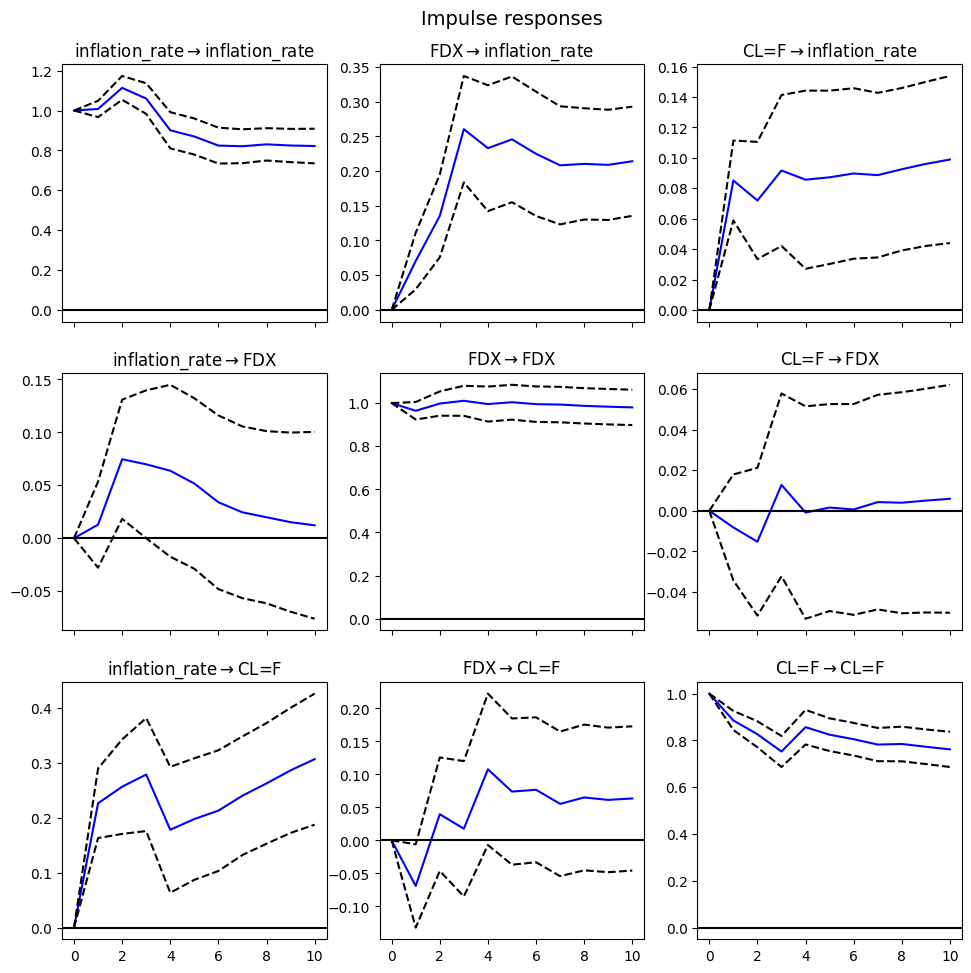

In [ ]:
# For 10 periods :
irf = results.irf(periods=10)

irf_response = irf.orth_irfs

# Print the IRF for a shock to the first variable (e.g., CL=F)
print("Orthogonal Impulse Responses for a shock to the first variable:")
print(irf_response[:, :, 0])

print(irf_response)
irf.plot()
plt.show()